In [54]:
import numpy as np
import pandas as pd
import yfinance as yf

# ML libraries
from keras.layers import Dense, Dropout, LSTM
from keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt
plt.style.use("fivethirtyeight")

import math
import datetime as dtm

In [74]:
# LOAD DATA
df = pd.read_csv("DTB.csv", skipinitialspace=True)

# CLEANING DATA
# Reverse dataframe starting with earliest stock as first index
df = df.iloc[::-1]
# Drop reversed index and add default integer index
df = df.reset_index()
df = df.drop('index', axis=1)

# Convert date column to standard date format
for idx, row in df.iterrows():
    row.Date = dtm.datetime.strptime(row.Date, "%m/%d/%y")
    # row.Date = row.Date.strftime("%Y-%m-%d")
    df.at[idx,"Date"] = row.Date

# Get start date and end date
start = df['Date'].iloc[0].strftime("%Y-%m-%d")
end = df['Date'].iloc[len(df) - 1].strftime("%Y-%m-%d")

# Set Date as default index
df.set_index('Date', inplace=True)
df

,Open,High,Low,Close,Volume
Date,,,,,
2005-01-03,19.22,19.22,19.22,19.22,2939.204814
2005-01-04,19.05,19.05,19.05,19.05,4070.798667
2005-01-06,19.05,19.05,19.05,19.05,8961.635477
2005-01-07,19.73,19.73,19.73,19.73,1469.602407
2005-01-10,20.41,20.41,20.41,20.41,18243.644280
...,...,...,...,...,...
2023-06-30,49.85,50.00,49.85,49.85,2800.000000
2023-07-03,49.80,49.80,48.00,48.10,311500.000000
2023-07-04,48.00,48.00,48.00,48.00,13300.000000


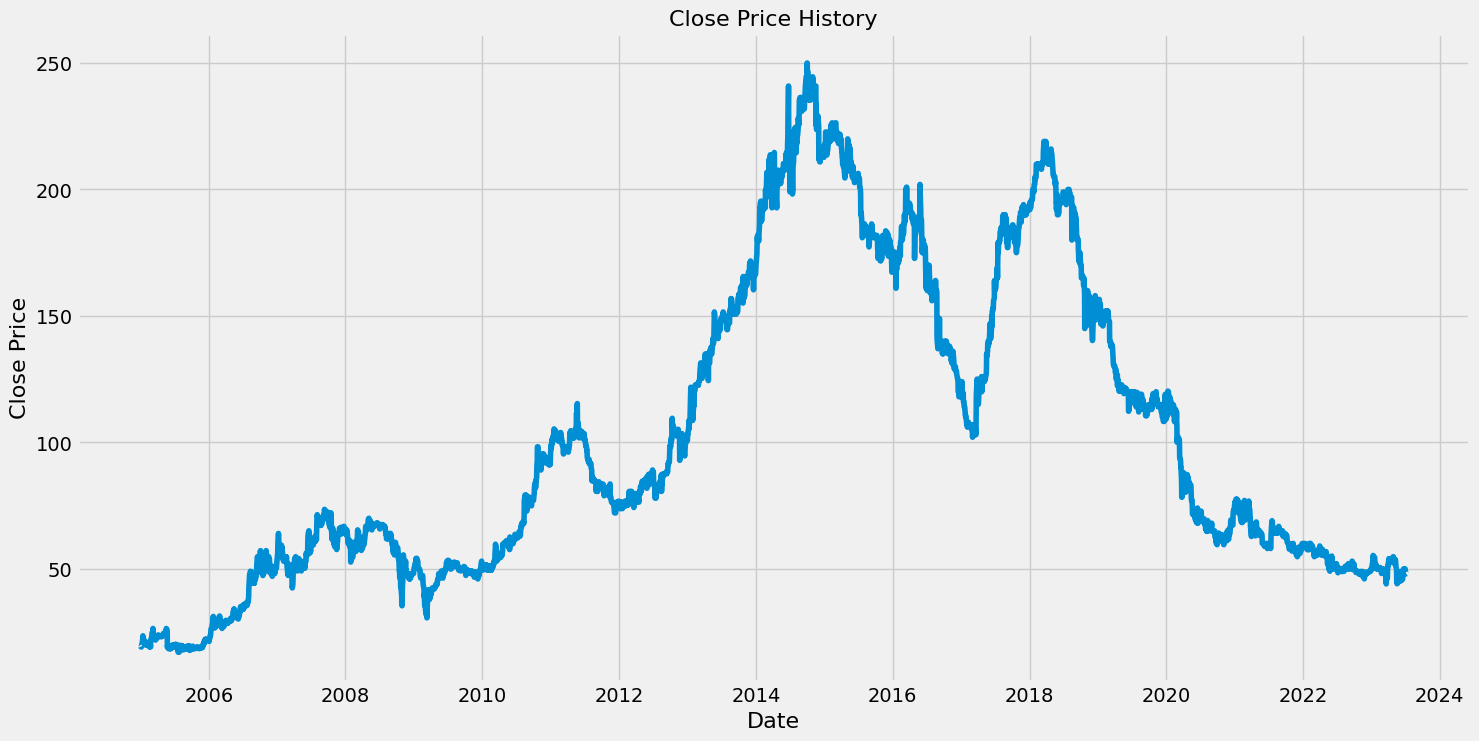

In [79]:
# Plot historical closing price
plt.figure(figsize=(16,8))
plt.title("Close Price History", fontsize=16)
plt.plot(df.Close)
plt.xlabel("Date", fontsize=16)
plt.ylabel("Close Price", fontsize=16)
plt.show()

In [80]:
# New dataframe with only close column
data = df.filter(["Close"])
data

,Close
Date,
2005-01-03,19.22
2005-01-04,19.05
2005-01-06,19.05
2005-01-07,19.73
2005-01-10,20.41
...,...
2023-06-30,49.85
2023-07-03,48.10
2023-07-04,48.00


In [81]:
# Convert the dataframe into a numpy array
dataset = data.values

In [82]:
# Get length of training and testing data
training_data_len = math.ceil(len(dataset) * 0.8)
test_data_len = len(dataset) - training_data_len
print("Training data length")
print(training_data_len)
print("Testing data length")
print(test_data_len)

Training data length
3514
Testing data length
878


In [83]:
# Scale down data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)
scaled_data

array([[0.00948539],
       [0.00875574],
       [0.00875574],
       ...,
       [0.13301   ],
       [0.13301   ],
       [0.1332246 ]])

In [84]:
# Testing dataset
test_data = scaled_data[training_data_len - 60: , :]

x_test = []
y_test = dataset[training_data_len:, :]

for i in range(60, len(test_data)):
    x_test.append(test_data[i-60: i, 0])

# Convert to numpy arrays
x_test = np.array(x_test)

In [85]:
# Reshape to 3D format
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
x_test.shape

(878, 60, 1)

In [86]:
# Load Saved Model
from keras.models import load_model
model = load_model("ke_lstm_model3")

In [87]:
# Get the models predicted values
predictions = model.predict(x_test)
# Scale down data
predictions = scaler.inverse_transform(predictions)

28/28 [==============================] - 1s 5ms/step


In [88]:
# Evaluate Model
# Get RMSE - root mean square error
# The closer the number to zero, the closer the predicted values to original values,
#  the better it was predicting 
rmse = np.sqrt(np.mean(predictions - y_test)**2)
rmse

1.5600279762424478

/var/folders/4f/xy4jvtjs1qg16v7xbbpgsc840000gn/T/ipykernel_61260/1293792117.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid["Predictions"] = predictions


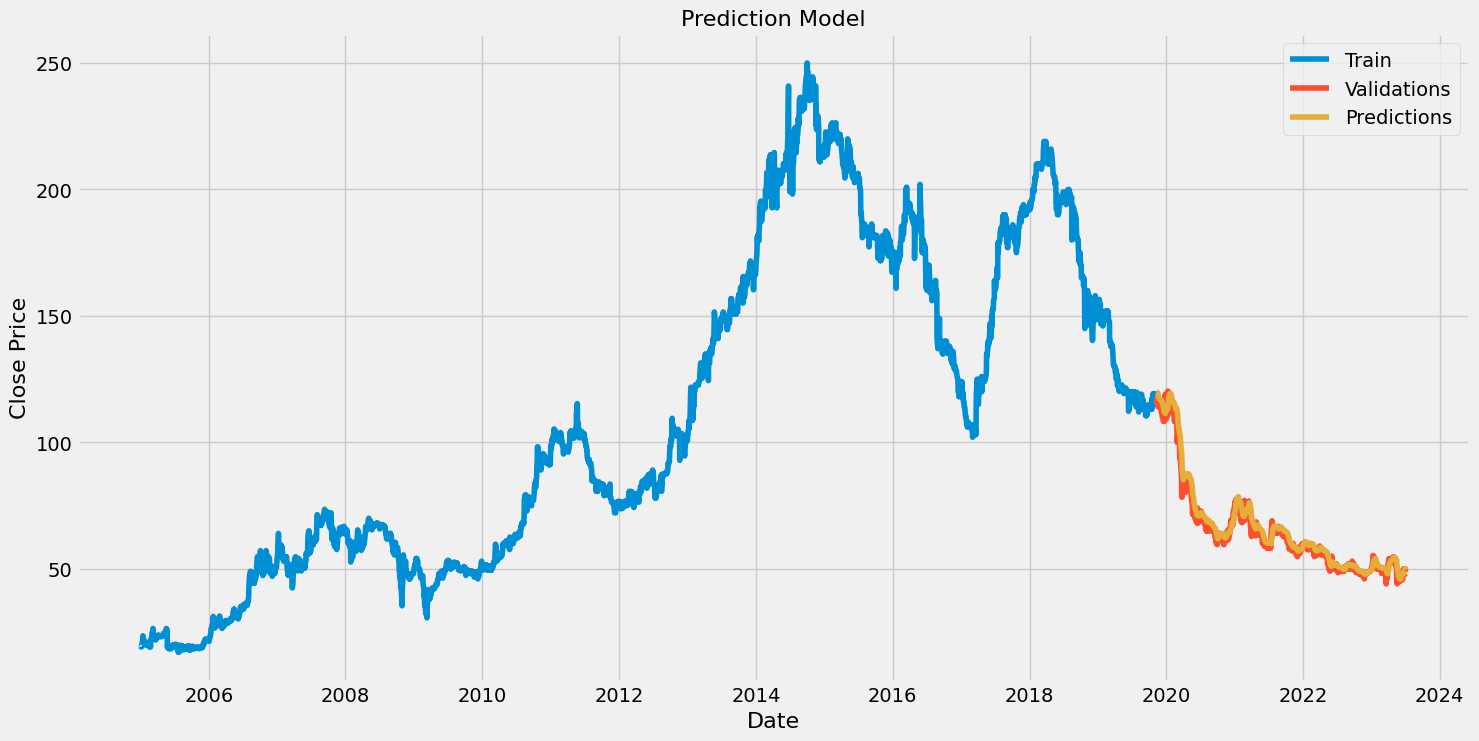

In [90]:
# Plot data
train = data[0: training_data_len] # from zero
valid = data[training_data_len:] # validation data
valid["Predictions"] = predictions

# Visualise data
plt.figure(figsize=(16,8))
plt.title("Prediction Model", fontsize=16)
plt.xlabel("Date", fontsize=16)
plt.ylabel("Close Price", fontsize=16)
plt.plot(train.Close)
plt.plot(valid[["Close", "Predictions"]])
plt.legend(["Train", "Validations", "Predictions"])
plt.show()

In [91]:
# Show valid and predicted
valid

,Close,Predictions
Date,,
2019-11-11,115.00,120.006180
2019-11-12,117.50,119.967949
2019-11-13,115.25,119.922478
2019-11-15,115.25,119.657425
2019-11-18,115.00,119.305428
...,...,...
2023-06-30,49.85,49.834892
2023-07-03,48.10,50.011837
2023-07-04,48.00,49.991108


In [92]:
# Predict for the next n_days => n_days can be 10, 20, 30, 60, 100 days e.t.c
n_days = 10
# Create new dataframe
new_df = df.filter(["Close"])

# Combined dataframe: Contains original close prices and predicted prices
combined = new_df

data = {
    "Date": [],
    "Close": []
}
next_n_days = pd.DataFrame(data)
next_n_days.set_index('Date', inplace=True)

last_day = dtm.datetime.strptime(end, "%Y-%m-%d")
# last_day = last_day - dtm.timedelta(days=1)
last_day = last_day.strftime("%Y-%m-%d")
last_day = dtm.datetime.strptime(last_day, "%Y-%m-%d")

for i in range(n_days):
    # Get the last 100 days closing price and convert dataframe to an array
    last_n_days = combined[-100:].values
    # Scale down data
    last_n_days_scaled = scaler.transform(last_n_days)
    X_test = []
    X_test.append(last_n_days_scaled)
    # Convert to numpy arrays
    X_test = np.array(X_test)
    # Reshape to 3D format
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
    # Predicted price
    pred_price = model.predict(X_test)
    # Scale up
    pred_price = scaler.inverse_transform(pred_price)
    
    #. Update dataframe with predicted value
    tomorrow = last_day + dtm.timedelta(days=1)
    # tomorrow = tomorrow.strftime("%Y-%m-%d")
    new_row = {
        "Date": [tomorrow],
        "Close": [pred_price[0].tolist()[0]]
    }
    last_day = tomorrow
    # last_day = dtm.datetime.strptime(last_day, "%Y-%m-%d")
    
    next_day = pd.DataFrame(new_row)
    next_day.set_index('Date', inplace=True)
    next_n_days = pd.concat([next_n_days, next_day])
    combined = pd.concat([combined, next_day])

1/1 [==============================] - 0s 12ms/step


In [93]:
new_df

,Close
Date,
2005-01-03,19.22
2005-01-04,19.05
2005-01-06,19.05
2005-01-07,19.73
2005-01-10,20.41
...,...
2023-06-30,49.85
2023-07-03,48.10
2023-07-04,48.00


In [94]:
next_n_days

,Close
Date,
2023-07-07,49.471077
2023-07-08,49.418262
2023-07-09,49.444695
2023-07-10,49.515141
2023-07-11,49.609924
2023-07-12,49.718128
2023-07-13,49.833740
2023-07-14,49.953499
2023-07-15,50.075668


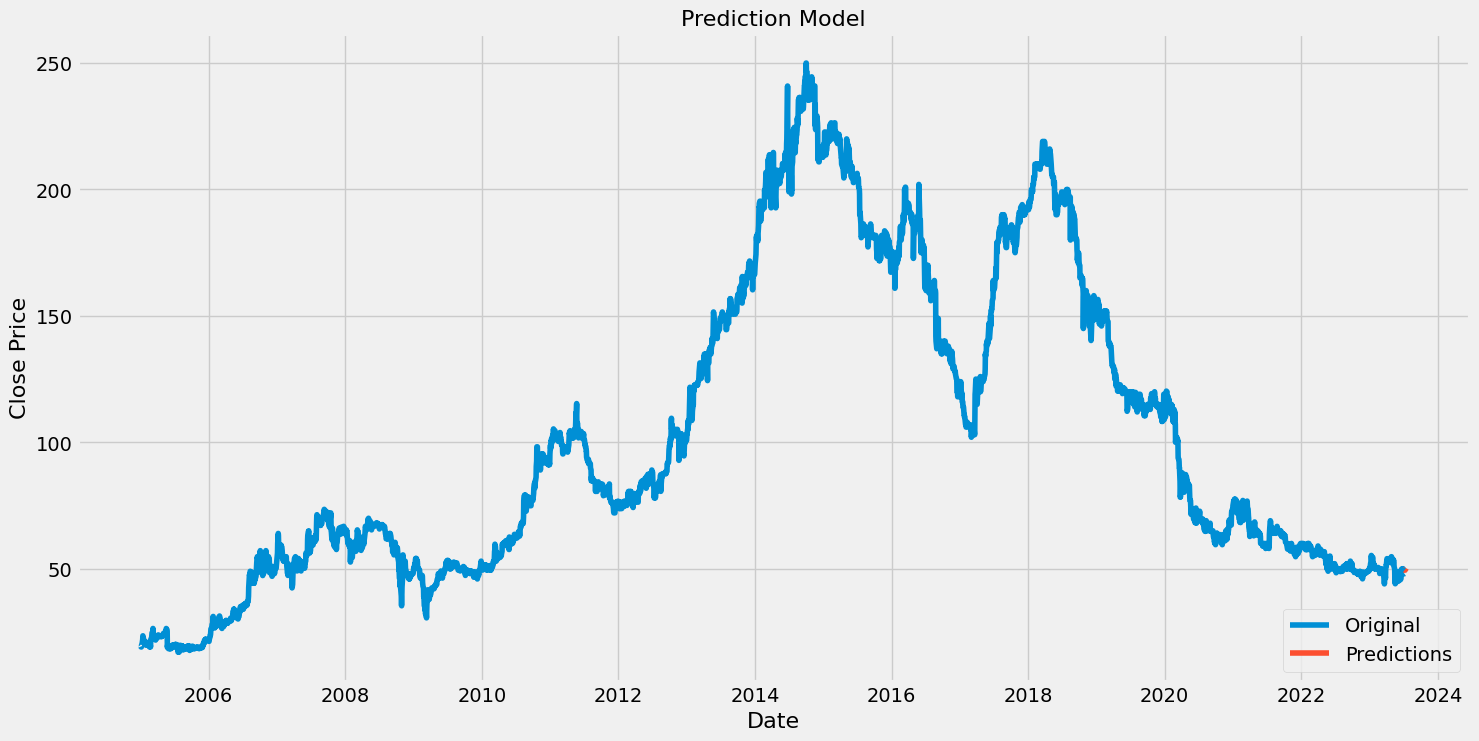

In [95]:
# Visualise data
plt.figure(figsize=(16,8))
plt.title("Prediction Model", fontsize=16)
plt.xlabel("Date", fontsize=16)
plt.ylabel("Close Price", fontsize=16)
plt.plot(new_df.Close)
plt.plot(next_n_days.Close)
# plt.legend(["Original", "Predictions"], loc="lower right")
plt.legend(["Original", "Predictions"])
plt.show()

In [97]:
# Show previous 3 months plus n_days (10, 30, 60 e.t.c) predictions 
prev_days = 90;
prev_n_days = new_df[-prev_days:]
prev_n_days.tail(10)

,Close
Date,
2023-06-22,49.70
2023-06-23,49.55
2023-06-26,49.50
2023-06-27,50.00
2023-06-29,50.00
2023-06-30,49.85
2023-07-03,48.10
2023-07-04,48.00
2023-07-05,48.00


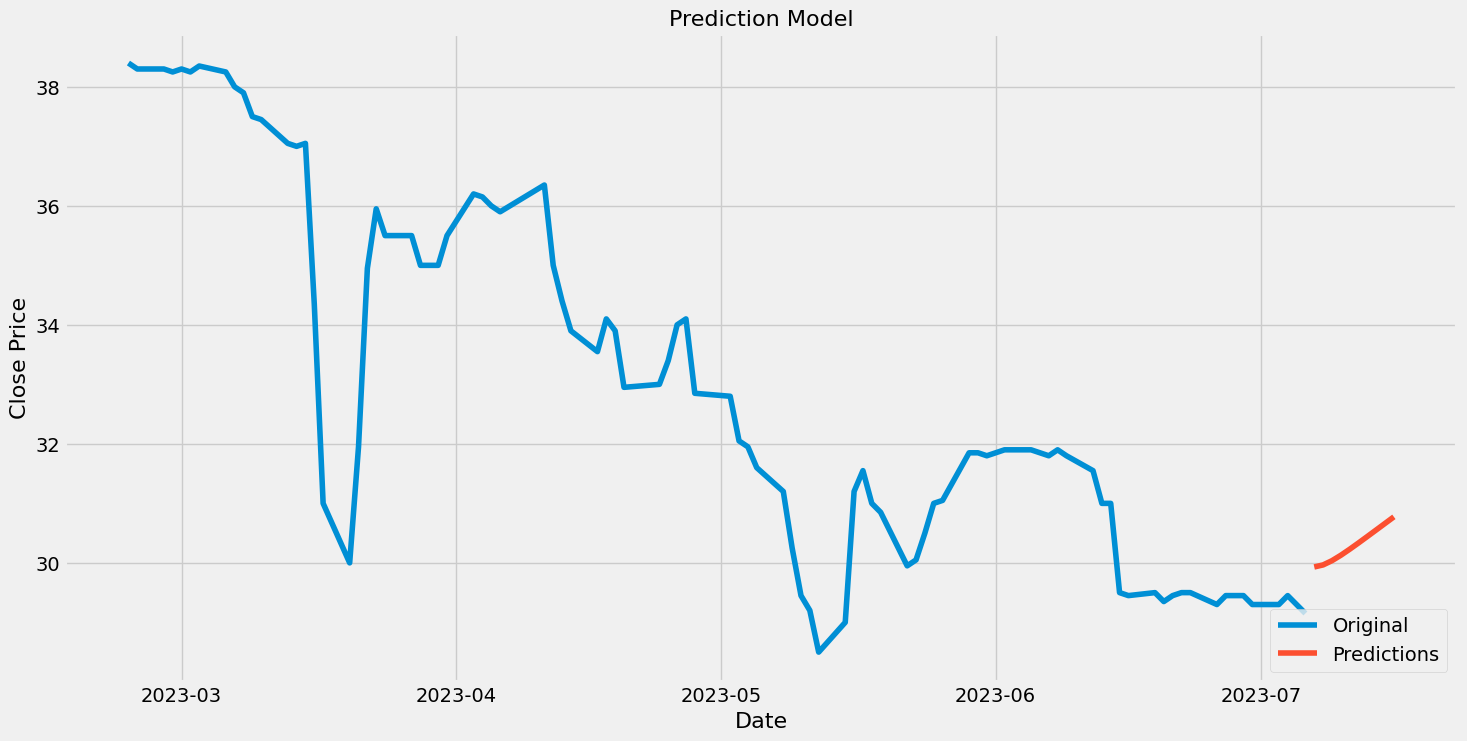

In [73]:
# Visualise data for previous 3 months
plt.figure(figsize=(16,8))
plt.title("Prediction Model", fontsize=16)
plt.xlabel("Date", fontsize=16)
plt.ylabel("Close Price", fontsize=16)
plt.plot(prev_n_days.Close)
plt.plot(next_n_days.Close)
plt.legend(["Original", "Predictions"])
plt.show()